<a href="https://colab.research.google.com/github/karthikmohan1702/EVA6/blob/main/S6_BatchNorm_Regularization/Batch_Layer_Group_Norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/EVA_6/S6_Batch_Grp_Layer_Norm/model")

In [4]:
from model import Net

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model
Let's start with the model we first saw

### BatchNorm

In [8]:
# dropout_value = 0.1
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 26

#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 24

#         self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(24),
#             nn.ReLU(),nn.Dropout(dropout_value)
#         ) # output_size = 10
       
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
#             nn.BatchNorm2d(12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 10

#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 8

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 6

#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
#             nn.BatchNorm2d(24),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 4

#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=4)
#         ) # output_size = 1

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#         ) 
#         #self.dropout = nn.Dropout(dropout_value)

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.pool1(x)
#         x = self.convblock3(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.gap(x)
#         x = self.convblock8(x)

#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

### Group Norm



In [9]:
# dropout_value = 0.1
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.GroupNorm(4, 12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 26

#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.GroupNorm(4, 12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 24

#         self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
#             nn.GroupNorm(6, 24),
#             nn.ReLU(),nn.Dropout(dropout_value)
#         ) # output_size = 10
       
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
#             nn.GroupNorm(4,12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 10

#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.GroupNorm(4, 12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 8

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.GroupNorm(4, 12),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 6

#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
#             nn.GroupNorm(6, 24),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 4

#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=4)
#         ) # output_size = 1

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#         ) 
#         #self.dropout = nn.Dropout(dropout_value)

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.pool1(x)
#         x = self.convblock3(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.gap(x)
#         x = self.convblock8(x)

#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

### Layer Norm

In [10]:
# dropout_value = 0.1
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.LayerNorm(26),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 26

#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.LayerNorm(24),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 24

#         self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
#             nn.LayerNorm(10),
#             nn.ReLU(),nn.Dropout(dropout_value)
#         ) # output_size = 10
       
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
#             nn.LayerNorm(10),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 10

#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.LayerNorm(8),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 8

#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.LayerNorm(6),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 6

#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
#             nn.LayerNorm(4),
#             nn.ReLU(),
#             nn.Dropout(dropout_value)
#         ) # output_size = 4

#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=4)
#         ) # output_size = 1

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#         ) 
#         #self.dropout = nn.Dropout(dropout_value)

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.pool1(x)
#         x = self.convblock3(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.gap(x)
#         x = self.convblock8(x)

#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
           Dropout-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,296
              ReLU-5           [-1, 12, 24, 24]               0
           Dropout-6           [-1, 12, 24, 24]               0
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 24, 10, 10]           2,592
              ReLU-9           [-1, 24, 10, 10]               0
          Dropout-10           [-1, 24, 10, 10]               0
           Conv2d-11           [-1, 12, 10, 10]             288
             ReLU-12           [-1, 12, 10, 10]               0
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

In [12]:
model.eval()

Net(
  (convblock1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock3): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(24, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (convblock6): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
#L1 Regularization
def l1_regularization(loss, lambda_l1):
  l1 = 0
  for p in model.parameters():
    l1 = l1 + p.abs().sum()
  loss = loss + lambda_l1*l1
  return loss

In [14]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, lambda_l1=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # L1 regularization
    if lambda_l1 > 0:
      loss = l1_regularization(loss, lambda_l1)

    train_losses.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [15]:
norm_reg_df = pd.DataFrame([["Batch_Norm + L1","BN", 0, 0.001],
                            ["Layer_Normalization","LN", 0, 0],
                            ["Group Normalization","GN", 4, 0]],
                            columns=["Normalization", "norm_code", "num_groups", "lambda_l1"])
                            
norm_reg_df

,Normalization,norm_code,num_groups,lambda_l1
0,Batch_Norm + L1,BN,0,0.001
1,Layer_Normalization,LN,0,0.000
2,Group Normalization,GN,4,0.000


In [16]:
train_losses_out = []
test_losses_out = []
train_acc_out = []
test_acc_out = []
title = []

for index, row in norm_reg_df.iterrows():
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  print("=="*60)
  print(row["Normalization"])
  print("=="*60)
  model = Net(norm=row["norm_code"], num_groups=row["num_groups"]).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

  EPOCHS = 25
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, lambda_l1=row["lambda_l1"])
    scheduler.step()
    test(model, device, test_loader)

  train_losses_out.append(train_losses)
  test_losses_out.append(test_losses)
  train_acc_out.append(train_acc)
  test_acc_out.append(train_acc)
  title.append(row["Normalization"])
  

  0%|          | 0/469 [00:00<?, ?it/s]

Batch_Norm + L1
EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.6911849975585938 Batch_id=468 Accuracy=90.70: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1446, Accuracy: 9556/10000 (95.56%)

EPOCH: 1


Loss=0.6170467734336853 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1440, Accuracy: 9536/10000 (95.36%)

EPOCH: 2


Loss=0.597034752368927 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:17<00:00, 27.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2116, Accuracy: 9333/10000 (93.33%)

EPOCH: 3


Loss=0.5440232157707214 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0851, Accuracy: 9736/10000 (97.36%)

EPOCH: 4


Loss=0.4160451292991638 Batch_id=468 Accuracy=95.84: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Accuracy: 9747/10000 (97.47%)

EPOCH: 5


Loss=0.3671468496322632 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9849/10000 (98.49%)

EPOCH: 6


Loss=0.32346242666244507 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 9821/10000 (98.21%)

EPOCH: 7


Loss=0.27297520637512207 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9809/10000 (98.09%)

EPOCH: 8


Loss=0.2634565532207489 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9844/10000 (98.44%)

EPOCH: 9


Loss=0.2654222249984741 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9827/10000 (98.27%)

EPOCH: 10


Loss=0.24139206111431122 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9886/10000 (98.86%)

EPOCH: 11


Loss=0.2560065984725952 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9885/10000 (98.85%)

EPOCH: 12


Loss=0.2108066976070404 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9873/10000 (98.73%)

EPOCH: 13


Loss=0.19370411336421967 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9869/10000 (98.69%)

EPOCH: 14


Loss=0.32129478454589844 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9879/10000 (98.79%)

EPOCH: 15


Loss=0.21454623341560364 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9891/10000 (98.91%)

EPOCH: 16


Loss=0.18233463168144226 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9898/10000 (98.98%)

EPOCH: 17


Loss=0.19491155445575714 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9895/10000 (98.95%)

EPOCH: 18


Loss=0.20718777179718018 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9897/10000 (98.97%)

EPOCH: 19


Loss=0.20166140794754028 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9898/10000 (98.98%)

EPOCH: 20


Loss=0.23683950304985046 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9882/10000 (98.82%)

EPOCH: 21


Loss=0.23261582851409912 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9899/10000 (98.99%)

EPOCH: 22


Loss=0.1930806040763855 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9894/10000 (98.94%)

EPOCH: 23


Loss=0.2199832946062088 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9888/10000 (98.88%)

EPOCH: 24


Loss=0.20000062882900238 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9892/10000 (98.92%)

Layer_Normalization
EPOCH: 0


Loss=0.07643138617277145 Batch_id=468 Accuracy=85.84: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0775, Accuracy: 9753/10000 (97.53%)

EPOCH: 1


Loss=0.08276216685771942 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.1600341647863388 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9852/10000 (98.52%)

EPOCH: 3


Loss=0.0729561597108841 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


Loss=0.13280215859413147 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.06290064752101898 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.03043789230287075 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.042305152863264084 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.11414682120084763 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.04602769389748573 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.029046813026070595 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.03943951800465584 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.06307448446750641 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.02389022894203663 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.03211183473467827 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.025716369971632957 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.023574337363243103 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.11959642171859741 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.02078252285718918 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.05211542919278145 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.03930363804101944 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.01924063079059124 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 22


Loss=0.046519696712493896 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.06848673522472382 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.009907552972435951 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

Group Normalization
EPOCH: 0


Loss=0.1009783074259758 Batch_id=468 Accuracy=87.99: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Accuracy: 9742/10000 (97.42%)

EPOCH: 1


Loss=0.08005445450544357 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9826/10000 (98.26%)

EPOCH: 2


Loss=0.07602044194936752 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9855/10000 (98.55%)

EPOCH: 3


Loss=0.06281714886426926 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.0775400921702385 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9834/10000 (98.34%)

EPOCH: 5


Loss=0.11554807424545288 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.016280533745884895 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.0779368206858635 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.0343400202691555 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.025290997698903084 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.048068538308143616 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.037630997598171234 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.05580008029937744 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.06009237840771675 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.02719014137983322 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.16800802946090698 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.030588606372475624 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.009425231255590916 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.03289257362484932 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.014315919019281864 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.045803215354681015 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.02133934199810028 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9934/10000 (99.34%)

EPOCH: 22


Loss=0.011935151182115078 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.02184196002781391 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.0036563975736498833 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]



Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)



In [17]:
dict_stat = {"train_losses" : train_losses_out,
            "test_losses" : test_losses_out,
            "train_acc" : train_acc_out ,
            "test_acc" : test_acc_out ,
            "title" : title 
            }

In [18]:
# for i in range(len(title)):
#   print(len(dict_stat["train_losses"][i]), len(dict_stat["test_losses"][i]), 
#       len(dict_stat["train_acc"][i]), len(dict_stat["test_acc"][i]), dict_stat["title"][i] )

11725 25 11725 11725 Batch_Norm + L1
11725 25 11725 11725 Layer_Normalization
11725 25 11725 11725 Group Normalization


In [19]:
len(train_acc_out)

3

In [20]:
len(title)

3

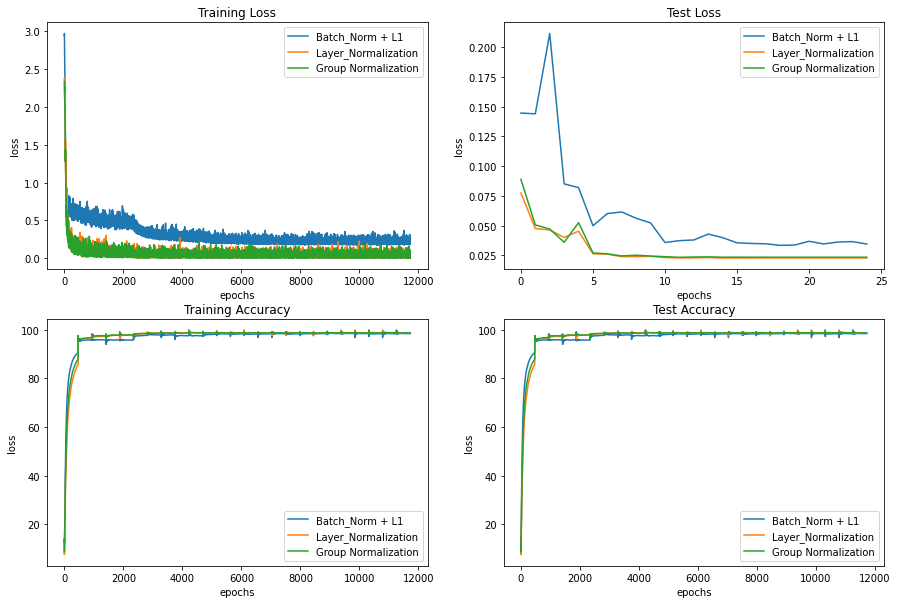

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
for i in range(len(title)):
  
  train_accuracy = dict_stat["train_acc"][i]
  train_losses = dict_stat["train_losses"][i]
  test_accuracy = dict_stat["test_acc"][i]
  test_losses  = dict_stat["test_losses"][i]
  title = dict_stat["title"][i]
  
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].set_title("Test Accuracy")

  axs[0, 0].plot(train_losses, label=title)
  axs[0,0].legend(loc='upper right')
  axs[0,0].set_xlabel('epochs')
  axs[0,0].set_ylabel('loss')

  axs[1, 0].plot(train_accuracy, label=title)
  axs[1,0].legend(loc='lower right')
  axs[1,0].set_xlabel('epochs')
  axs[1,0].set_ylabel('loss')

  axs[0, 1].plot(test_losses, label=title)
  axs[0,1].legend(loc='upper right')
  axs[0,1].set_xlabel('epochs')
  axs[0,1].set_ylabel('loss')

  axs[1, 1].plot(test_accuracy, label=title)
  axs[1,1].legend(loc='lower right')
  axs[1,1].set_xlabel('epochs')
  axs[1,1].set_ylabel('loss')